**Author:** Max Aragón (1)<br>
**Professor:** lucas.drumetz@imt-atlantique.fr (2)<br>
**Affiliations:** (1) Université Bretagne Sud and (2) IMT Atlantique<br>
**Course:** Active and multitemporal remote sensing <br>
**Date:** 2022-11-20

<div class="alert alert-block alert-success">
<h2><center>Lab Session: Introduction to spectral unmixing</center></h2>

The goal of this lab is to get familiar with the unmixing of hyperspectral images and the techniques to solve this problem. We will implement a simple unmixing chain on an ideal simulated case first, and then on a real hyperspectral image. Various algorithms have been developed for this purpose, including LMM (Linear Mixing Model), FCLSU (Fully Constrained Least Squared Unmixing), SCLSU (Scaled Constrained Least Squares Unmixing), ELMM (Extended Linear Mixing Model) and RELMM (Robust Extended Linear Mixing Model).

In [1]:
import os
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt
#os.chdir('/Users/max/Desktop/UBS/Unmixing')
from pca_viz import pca_viz

# Part I: Simulated data

In this section, we will generate some simulated hyperspectral data by drawing abundances from a uniform distribution on the simplex, then implement an endmember extraction algorithm, and finally estimate abundances.

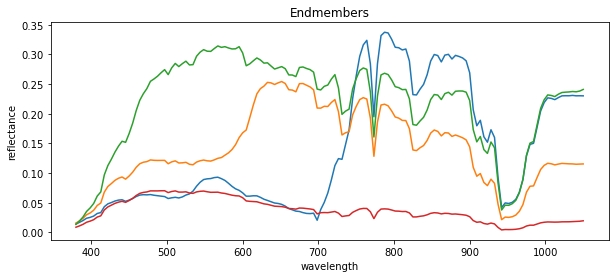

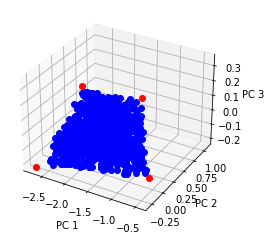

In [3]:
## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

endmembers = sio.loadmat("endmembers_houston.mat")
L = np.shape(endmembers['S0'])[0]
wavelengths = np.linspace(380,1050,L) #
S = endmembers['S0'][:,0:4]

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)
plt.xlabel('wavelength')
plt.ylabel('reflectance')
plt.title('Endmembers')

synth_data = np.dot(S,A_synth_true) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space (even though they actually live in an L-dimensional space)

# Successive Projection Algorithm (SPA)

How many spectral bands are there? Can you recognize some of the materials by their spectra? Implement the Successive Projection Algorithm (SPA) as seen during the lecture. Apply it on the synthetic dataset. Check the quality of the extracted endmembers. Are they exactly the same as the original endmembers? Why? Try with 4 endmembers.

In [17]:
print(f'Number of spectral bands: {synth_data.shape[0]}')

Number of spectral bands: 144


[43, 551, 866, 281]


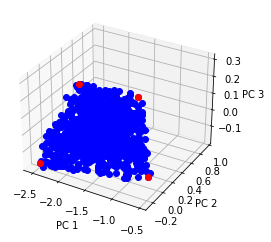

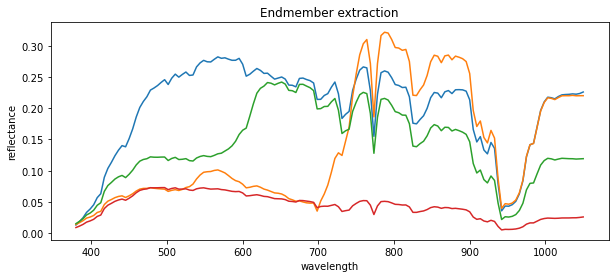

In [4]:
P = 4 # number of endmembers

def SPA(data,P):
    data_to_project = data # initialize projected data
    endmember_coordinates = [] # initialize list of endmember indices
    for i in range(P):
        max_norm = np.argmax(np.linalg.norm(data_to_project,axis=0))
        u = data_to_project[:,max_norm]/np.linalg.norm(data_to_project[:,max_norm])
        data_to_project = data_to_project - np.dot(np.outer(u,u), data_to_project)
        endmember_coordinates.append(max_norm)
    
    endmembers = data[:,endmember_coordinates]
    return endmembers,endmember_coordinates
        
endmembers_synth,endmember_coordinates_synth = SPA(synth_data,P)

print(endmember_coordinates_synth)

# visualize the results



pca_viz(synth_data,endmembers_synth)

plt.figure()
plt.rcParams["figure.figsize"] = (5,4)
plt.plot(wavelengths,endmembers_synth)
plt.title('Endmember extraction')
plt.xlabel('wavelength')
plt.ylabel('reflectance')
plt.show()

# Endmember comparison (SPA vs Original)

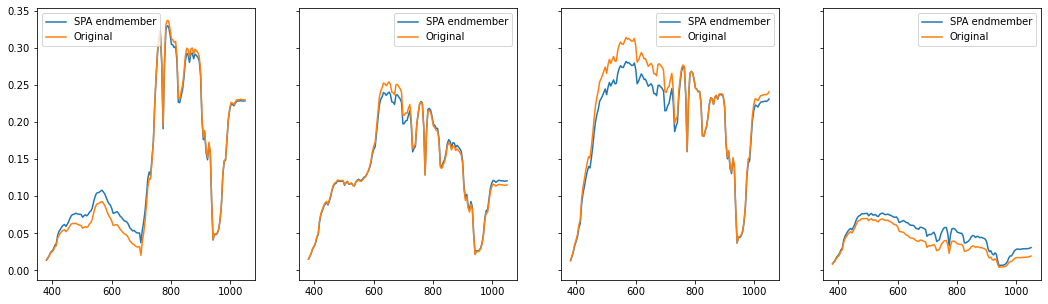

In [141]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, sharey=True, figsize=(18,5))

ax1.plot(wavelengths,endmembers_synth[:,1], label='SPA endmember')
ax1.plot(wavelengths,S[:,0], label='Original')

ax2.plot(wavelengths,endmembers_synth[:,2], label='SPA endmember')
ax2.plot(wavelengths,S[:,1], label='Original')

ax3.plot(wavelengths,endmembers_synth[:,0], label='SPA endmember')
ax3.plot(wavelengths,S[:,2], label='Original')

ax4.plot(wavelengths,endmembers_synth[:,3], label='SPA endmember')
ax4.plot(wavelengths,S[:,3], label='Original')

for ax in ax1,ax2,ax3,ax4:
    ax.legend()
plt.show()

Endmembers are similar but not exactly the same, this is possibly due to outliers in the data

# Fully Constrained Least Squares Spectral Unmixing by Simplex Projection

In [13]:
# compute the abundances using the FCLSU algorithm (constrained least squares) and compare with the real values.

from FCLSU import FCLSU

A_synth = FCLSU(synth_data,endmembers_synth)

# Endmember abundance comparison

Compare for a few pixels the estimated abundances with the true ones. Are they easily comparable? Why? How can we fix this?

In [144]:
(A_synth_true == A_synth).all()

False

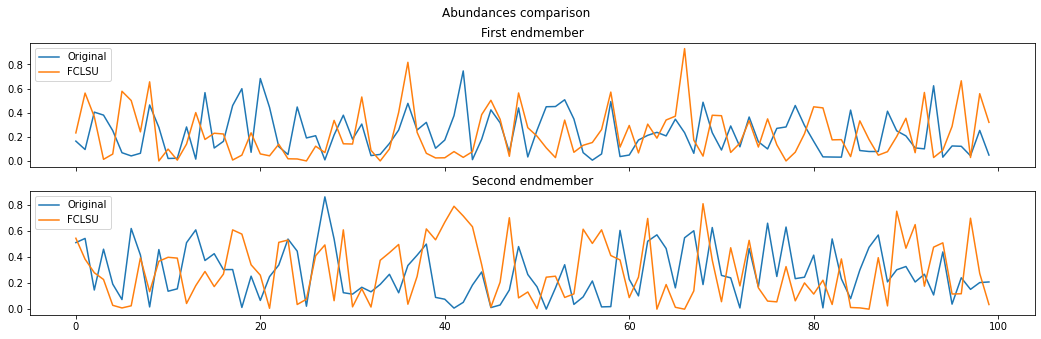

In [184]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

plt.suptitle('Abundances comparison')

ax1.plot(A_synth_true[0,0:100], label='Original')
ax1.plot(A_synth[0,0:100], label='FCLSU')
ax1.set_title('First endmember')

ax2.plot(A_synth_true[1,0:100], label='Original')
ax2.plot(A_synth[1,0:100], label='FCLSU')
ax2.set_title('Second endmember')

for ax in ax1,ax2:
    ax.legend()

plt.show()

Estimated abundances differ from true ones and not easily comparable.  

# Part II: Real Data

In this part, we are going to unmix a real image acquired by the airborne sensor AVIRIS over Calaveras Reservoir, California, USA. Don't hesitate to use Google maps to access a higher spatial resolution image over this scene:

https://www.google.fr/maps/place/Calaveras+Reservoir/@37.4777265,-121.8213273,4840m/data=!3m2!1e3!4b1!4m5!3m4!1s0x808fd026ab19d673:0x21f48327a3b3c623!8m2!3d37.4734195!4d-121.8192506

(199, 199, 192)
1.0
0.0


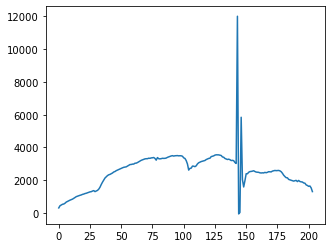

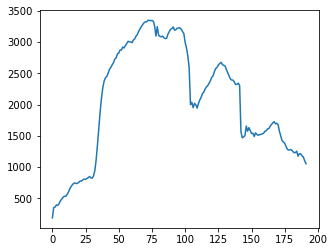

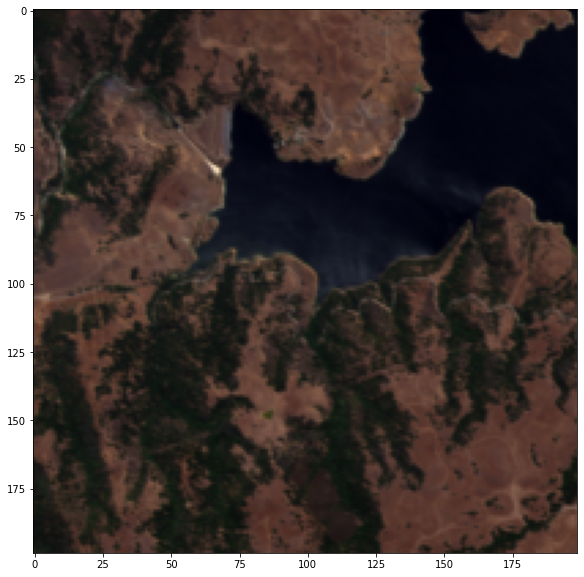

In [6]:
data = sio.loadmat("moffett1.mat")
im = data['im'].astype("double")
imrgb = data['imrgb']

plt.figure()
plt.plot(im[50,50,:]) # plot one pixel

im = np.delete(im,slice(200,224),axis =2) # delete noisy or corrupted bands
im = np.delete(im,slice(142,150),axis =2)
plt.figure()
plt.plot(im[35,24,:]) # plot one pixel after this

im = im[1:200,1:200,:] # select crop on which we will work

im = (im - np.amin(im))/(np.amax(im)-np.amin(im)) # rescale image

print(im.shape)
print(np.amax(im))
print(np.amin(im))


plt.figure(figsize=(20,10))
plt.imshow(imrgb[1:200,1:200,:])

[m,n,L] = im.shape
rgb_small =imrgb[1:200,1:200,:]

plt.show()

# Reshape the hyperspectral image as a $L\times N$ matrix

In [7]:
height, width, channels = np.shape(im)
im_r = np.reshape(im,(height*width,channels)).T 

Channels, Pixels = im_r.shape
print(f'Number of channels: {Channels}')
print(f'Number of pixels: {Pixels}')

Number of channels: 192
Number of pixels: 39601


# Extract endmembers using SPA

In [8]:
endmembers,endmember_coordinates = SPA(im_r,4); endmembers.shape

(192, 4)

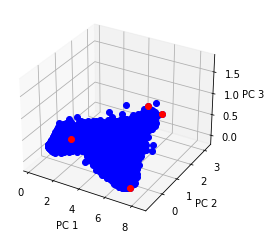

In [10]:
pca_viz(im_r,endmembers)

In [11]:
endmember_coordinates

[11609, 35290, 27740, 29339]

# Compute abundances

In [14]:
Abundance = FCLSU(im_r,endmembers)

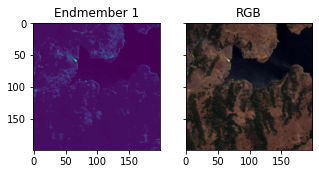

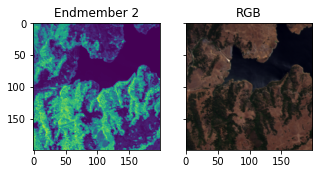

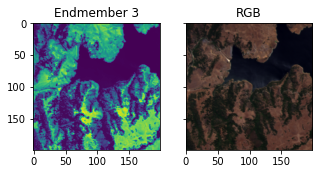

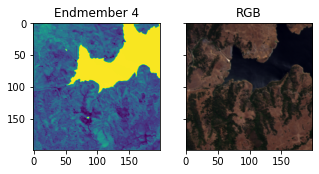

In [52]:
for i in range(endmembers.shape[1]):
    fig, ax = plt.subplots(1,2, sharey=True)
    A_im = Abundance[i].reshape(height, width ,-1)
    ax[0].imshow(A_im[:,:])
    ax[0].set_title(f'Endmember {i+1}')
    ax[1].imshow(imrgb[1:200,1:200,:])
    ax[1].set_title('RGB')
    plt.show()

# Unmixing with more endmembers

In [50]:
E = 8 # num of endmembers

def abundance_maps(hyperspectral_im, E:int):
    height, width, channels = np.shape(hyperspectral_im) # split data
    im_r = np.reshape(im,(height*width,channels)).T # reshape to fit data
    endmembers,endmember_coordinates = SPA(im_r,E); endmembers.shape # Perform SPA
    Abundance = FCLSU(im_r,endmembers) # Compute abundance
    for i in range(endmembers.shape[1]):
        fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
        A_im = Abundance[i].reshape(height, width ,-1)
        ax[0].imshow(A_im[:,:])
        ax[0].set_title(f'Endmember {i+1}')
        ax[1].imshow(imrgb[1:200,1:200,:])
        ax[1].set_title('RGB')
        plt.show()

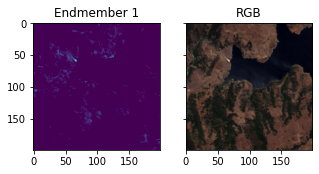

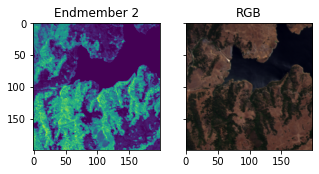

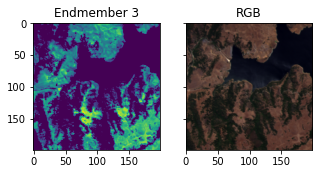

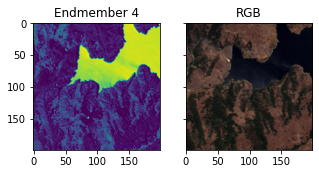

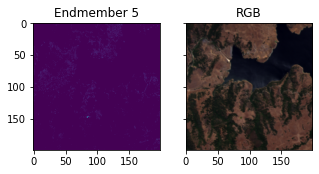

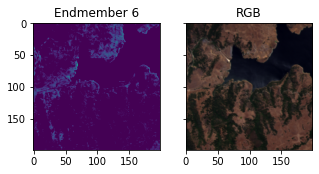

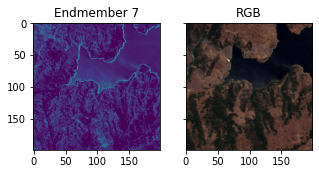

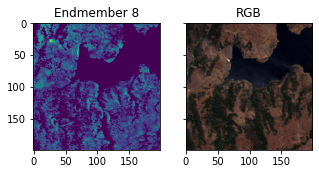

In [51]:
abundance_maps(im, E)

# Abundance with sparsity promoting regularisation

In [ ]:
from social_unmixing import social_unmixing

# params
groups = np.arange(0,4)
rho = 10
maxiter_ADMM = 200
algo = "fractional"
fraction = 0.5
tol_a = 10**(-5)
verbose = False

# regularization parameter
Lambda = 0.5 # this values controls the sparsity level. The larger the value, the sparser the solution.

A_sparse = social_unmixing(
    im_r,endmembers,
    groups,
    Abundance,
    Lambda,
    rho,
    maxiter_ADMM,
    algo,
    fraction,
    tol_a,
    verbose)

In [32]:
A_sparse.shape

(4, 39601)

In [55]:
E = 4 # num of endmembers

def abundance_maps_regularisation(hyperspectral_im, E:int, Abundance):
    height, width, channels = np.shape(hyperspectral_im) # split data
    im_r = np.reshape(im,(height*width,channels)).T # reshape to fit data
    endmembers,endmember_coordinates = SPA(im_r,E); endmembers.shape # Perform SPA
    #Abundance = FCLSU(im_r,endmembers) # Compute abundance
    for i in range(endmembers.shape[1]):
        fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
        A_im = Abundance[i].reshape(height, width ,-1)
        ax[0].imshow(A_im[:,:])
        ax[0].set_title(f'Endmember {i+1}')
        ax[1].imshow(imrgb[1:200,1:200,:])
        ax[1].set_title('RGB')
        plt.show()

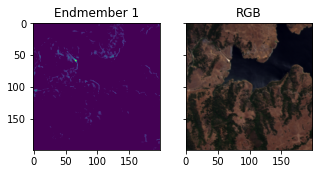

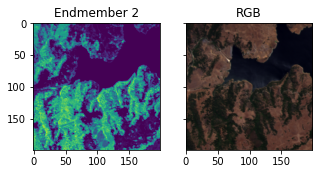

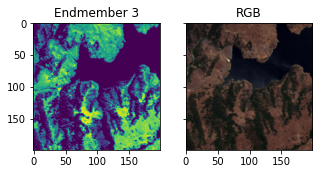

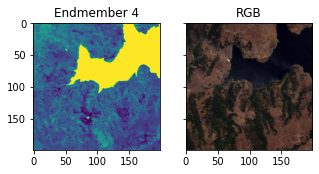

In [56]:
abundance_maps_regularisation(im, E, A_sparse)